<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Customization_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will contains the code and concepts from the TensorFlow documentation on customization. 

## Eager Execution in TensorFlow 

TensorFlow's eager execution is an imperative programming environment that evaluates the operation immediately, without building graphs. 

> Operations return concrete values instead of constructing a computational graph to run later. 


Eager execution is flexible because of the following reasons: 

- An intuitive interface. 
- Easier debugging, use standard python debugging tools for immediate error reporting. 
- Natural control flow, using pythons control flow instead of graph control flow. 





In [2]:
# Enabling the eager execution 
import tensorflow as tf 
tf.executing_eagerly()

True

In [ ]:
# We get the results immediately 
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

Enabling eafer execution changes how TensorFlow operations behave,

In [ ]:
# TensorFlow imports
import timeit
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense

# Model building
inputs = Input(shape=(28, 28)) 
x = Flatten()(inputs) 
x = Dense(256, "relu")(x)
x = Dense(256, "relu")(x) 
x = Dense(256, "relu")(x) 
outputs = Dense(10, "softmax")(x) 

input_data = tf.random.uniform([100, 28, 28])

# Eager Execution
eager_model = Model(inputs=inputs, outputs=outputs)
print("Eager time:", timeit.timeit(lambda: eager_model(input_data), number=10000))

#Graph Execution 
graph_model = tf.function(eager_model) # Wrap the model with tf.function 
print("Graph time:", timeit.timeit(lambda: graph_model(input_data), number=10000))

Eager execution is fine for building small models and rapid experimentation. But when have a complex and large model we can opt for Graph execution. 

In reality graph execution might be slower but more efficient than the eager execution. The default execution of TensorFlow 2x + is eager execution and we can opt for graph execution using the `tf.function()` can make graphs out of our programs. 


The `tf.function()` converts a Python function to its graph representation. So we add the `@tf.function` at top before the code or wrap the eager execution function. 

This will help you create performant and portable models, and it is required to use `SavedModel`.





In [ ]:
@tf.function
def add(a , b):
  return a + b 

add(tf.ones([2, 2]) , tf.ones([2, 2]))

In [ ]:
v = tf.Variable(5.0)

# Using automatic differentiation 
with tf.GradientTape() as tape:
  result = add(a = v , b = 5.0)
tape.gradient(result , v)

**Why we use `tf.Variable` while creating the weights in a neural net?** 

The values produced by the `tf.Tensor` are immutable and we can't modify them. And we cant use these regular tensors to implement weights in a neural network and they get changed during the back prop. 

So thats why we use `tf.Variable`

In [ ]:
# Creating a tensor with tf.variable 
v = tf.Variable([[1, 2, 3,], [4 ,5 ,6]])
v

In [ ]:
v.assign(2 * v)

In [ ]:
 # Assigning in a index 
 v[0 , 1].assign(14)

In [ ]:
tf.strings.to_number('8448')

### Customization basics: Tensors and operations 

- Import the required package
- Create and use tensors
- Use GPU acceleration
- Demonstrate tf.data.Dataset


##### Tensors 
A tensor is a multi-dimensional array, which is of dtype `tf.Tensor` and has a shape. 

The `tf.tensor` can reside in GPU accelerator and we can use regular tensor operations. 

In [ ]:
import tensorflow as tf 

In [ ]:
tf.square(2) + tf.square(3)

In [ ]:
# Each tf.tensor has a shappe and a datatype 
x = tf.matmul([[1]] , [[2,3]])

x.shape  , x.dtype

Converting between a TensorFlow `tf.Tensor`s and a Numpy `ndarray` is easy: 

- Tensorflow operations automatically convert Numpy ndarrays to Tensors 
- Numpy operations automatically convert Tensors to Numpy ndarrays. 

Tensors are explicitly converted to Numpy ndarrays using their `.numpy()` method.

In [ ]:
import numpy as np 

ndarray = np.ones([3 ,3])
tensor = tf.multiply(ndarray , 42)
print(f'{tensor} \n')

# Using the numpy operations to convrt tensors to numpy arrays 
print(f'{np.add(tensor , 1)}\n')

print(f'{tensor.numpy()}\n')

TensorFlow automatically decides which device to execute an operation and copies tensors to the devices, if needed. 

> TensorFlow operations can be expilictly places on a specific devices using the `tf.device` context manager. 

In [ ]:
import time 

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time() - start 

  print("10 loops: {:0.2f}ms".format(1000*result))

In [ ]:
# Force execution on CPU 
print('On CPU:')

with tf.device('CPU:0'):
  x = tf.random.uniform([1000 , 1000])
  assert x.device.endswith('CPU:0')
  time_matmul(x)

In [ ]:
# Forece execution on GPU (running on gpu)
if tf.config.list_physical_devices('GPU'):
  print('On GPU:')
  with tf.device('GPU:0'): 
    x = tf.random.uniform([1000 , 1000])
    assert x.device.endswith('GPU:0')
    time_matmul(x)

## Custom Layers 



In [ ]:
# Using  a pre-existing layer 
layer = tf.keras.layers.Dense(100)

layer(tf.zeros([10 ,5]))[0]

Layers have many useful methods, for example we can inspect all variables in a layer using `layer.variables` and trainable variables using `layer.trainable_variables`. 

When we talk about variables, it means the weights and biases. 

In [ ]:
# Accessing the weight and biases 
layer.variables[0][:1] , layer.variables[1][:10]

In [ ]:
# We can even explicitly call the kernel and bias 
layer.kernel[0] , layer.bias[:10]

### Implementing a custom layer 

The best way to implement our own layer is extending the `tf.keras.Layer` class and implementing: 
- The `__init__` where we can do all input-independent initialization. 
- `build` we can use this when we know the shapes of the input tensors and can do the rest of the initialization. 
- `call` where we do the forward computation. 

At times we can even neglect the usage of `build` and create the variables in the constructor itself. 


> Well the main advantage of using `build` is that it enables late variable creation based on the shape of the inputs the layer will operate on.

> Creating variables in `__init__` would mean that shapes required to create the variables will need to be explicitly specified.

In [ ]:
# Creating a custom layer 
class MyDenseLayer(tf.keras.layers.Layer):
  
  # The constructor 
  def __init__(self , num_outputs , **kwargs):
    super(MyDenseLayer ,self).__init__(**kwargs)
    self.num_outputs = num_outputs 

  # Defining the build function (creating the initializer etc..)
  def build(self , input_shape):
    self.kernel = self.add_weight(name = 'kernel_weights' , 
                                shape = [int(input_shape[-1]) , 
                                         self.num_outputs] , 
                                  initializer = tf.keras.initializers.RandomNormal() ,
                                  trainable = True )
    
    self.bias = self.add_weight(name = 'bias' , 
                                shape = [self.num_outputs,] , 
                                initializer = tf.keras.initializers.Zeros())
    
  # Forward propagation 
  # The call method takes the input 
  def call(self, inputs):
    return tf.matmul(inputs , self.kernel) + self.num_outputs # added bias to prevent zero 

In [ ]:
# Creating an object of the layer we've created 
layer = MyDenseLayer(num_outputs= 10)

In [ ]:
# Passing in a dummy input to test our custom layer 
# Now we're calling the layer so the build function will get in action
layer(tf.ones([10 , 5]))

### Models: Composing layers 

Many machine learning models are implemented by composing the existing layers. For example, each **residual block in a resnet** is a composition of convolutions, batch normalizations and a shortcut layers. 

> Layers can be nested inside the other layers 

When we inherit from the `tf.keras.Model` we get the methods like fit , evaluate annd save. One other feature provided by the `tf.keras.Model` is that in addition to tracking the variables, as `tf.keras.Model` also tracks its internal layers, making them easier to inspect each layers. 


In [ ]:
# Building a ResNet Block from the Model method 

class ResnetIdentityBlock(tf.keras.Model):

  # Constructor 
  def __init__(self , kernel_size , filters , **kwargs):
    super(ResnetIdentityBlock , self).__init__(**kwargs)

    # Unpacking the list of filters 
    filters_1 , filters_2 , filters_3 = filters 

    # Initializing the layers 
    self.conv2a = tf.keras.layers.Conv2D(filters_1 ,(1 , 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters_2 , kernel_size= kernel_size , strides= (1, 1))
    self.bn2b = tf.keras.layers.BatchNormalization() 

    self.conv2c = tf.keras.layers.Conv2D(filters_3 , (1 , 1))
    self.bn2c = tf.keras.layers.BatchNormalization() 


  # The forward propagation (building the model here )

  def call(self , input_tensor , training = False):

    # Building a functional model of how the resnet block is connected 
    #x = tf.expand_dims(input_tensor , axis = 1)
    print(input_tensor.shape)
    x = self.conv2a(input_tensor)
    print(x.shape)
    x = self.bn2a(x , training = training)
    print(x.shape)
    x = tf.nn.relu(x) 

    print(x.shape)
    x = self.conv2b(x)
    print(x.shape)
    x = self.bn2b(x , training = training)
    print(x.shape)
    x = tf.nn.relu(x)

    print(x.shape)
    x = self.conv2c(x)
    print(x.shape)
    x = self.bn2c(x , training = training)
    print(x.shape)

    x += input_tensor
    print(x.shape)
    return tf.nn.relu(x)


# Using the above model classs and creacting a Resnet Block 
block = ResnetIdentityBlock(1 , filters = [1 ,2 ,3])

In [ ]:
# Dummy inputs 
block(tf.zeros([1 ,2 ,3 ,3]))

In [ ]:
# Accessing the block layers
block.layers

In [ ]:
block.variables

In [ ]:
len(block.variables)

In [ ]:
# We can get the summary (because we inherited the Model class)
block.summary()

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

(X_train , y_train) , (X_test , y_test) = mnist.load_data()

X_train.shape , X_test.shape , y_train.shape , y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [30]:
X_train = X_train.reshape(-1 , 28 ,28 ,1).astype('float32') / 255.0
X_test = X_test.reshape(-1 , 28 ,28 ,1).astype('float32') / 255.0


X_train_new = X_train.reshape(-1 , 28 *28).astype('float32') / 255.0
X_test_new = X_test.reshape(-1 , 28*28).astype('float32') / 255.0


Lets create a block which does the following: 
- CNN 
- Batch Norm
- ReLu 

But we want to do this for 10 times. To reduce the hustle we can create a class which will take care of these repititions. 

In [6]:
class CNNBlock(tf.keras.layers.Layer):

    # Constructor where we initialize the things we are going to use
    def __init__(self, out_channels , kernel_size = 3 , **kwargs):
      super(CNNBlock , self).__init__(**kwargs)

      # Creating a cnn block 
      self.conv = layers.Conv2D(out_channels , kernel_size , padding ='same')
      self.bn = layers.BatchNormalization()
  


    # Forward method 
    def call(self , input_tensor , training = False):
      
      x = self.conv(input_tensor)
      x = self.bn(x , training = training)
      x = tf.nn.relu(x)
      return x





In [9]:
# Reusing this multiple times 
model = tf.keras.Sequential([
  CNNBlock(32), 
  CNNBlock(64) , 
  CNNBlock(128), 
  layers.Flatten(),
  layers.Dense(10 , activation= 'softmax')
])

model.compile(optimizer = 'adam' , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              metrics = ['accuracy'])

model.fit(X_train , y_train , batch_size = 64 , epochs = 3 , verbose = 2)

Epoch 1/3
938/938 - 27s - loss: 0.6023 - accuracy: 0.9451
Epoch 2/3
938/938 - 10s - loss: 0.0914 - accuracy: 0.9820
Epoch 3/3
938/938 - 10s - loss: 0.0330 - accuracy: 0.9905


In [25]:
# We are going to create a ResBlock (similar to resnet)
class ResBlock(tf.keras.layers.Layer):

  def __init__(self , channels , **kwargs):
    super(ResBlock , self).__init__(**kwargs)

    self.cnn1 = CNNBlock(channels[0])
    self.cnn2 = CNNBlock(channels[1])
    self.cnn3 = CNNBlock(channels[2])
    self.pooling = tf.keras.layers.MaxPool2D()
    self.identity_mapping = layers.Conv2D(channels[1] , kernel_size=3 , padding = 'same')

  def call(self, input_tensor , training = False):
    x = self.cnn1(input_tensor , training = training)
    x = self.cnn2(x , training = training)
    x = self.cnn3(x + self.identity_mapping(input_tensor) , training = training) # performing the skip connection 
    return self.pooling(x)

In [28]:
class ResnetLike(tf.keras.Model):

  # it has the functionality of layers and additional model functionalities (model.fit, evaluate......)

  def __init__(self , num_classes = 10 , **kwargs):
    super(ResnetLike , self).__init__(**kwargs)

    self.block_1 = ResBlock(channels= [32 ,32, 64])
    self.block_2 = ResBlock([128 , 128 , 256])
    self.block_3 = ResBlock([128 , 256 , 512])
    self.pool = layers.GlobalAveragePooling2D() # or flatten
    self.classifier = layers.Dense(num_classes)

  def call(self, input_tensor , training = False):
    x = self.block_1(input_tensor , training = training)
    x = self.block_2(x , training = training)
    x = self.block_3(x , training = training)
    x = self.pool(x)
    return self.classifier(x)

  # This trick will print the output shapes during the model summary 
  # This will overwrite the call method 
  def model(self):
    x = layers.Input(shape = (28 , 28 , 1))
    return tf.keras.Model(inputs = [x] , outputs = self.call(x))

resnet_model = ResnetLike()
resnet_model.compile(optimizer = 'adam' , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              metrics = ['accuracy'])

resnet_model.fit(X_train , y_train , batch_size = 64 , epochs = 10 , verbose = 2)
resnet_model.evaluate(X_test , y_test , batch_size = 64 , verbose = 2)
#resnet_model.model().summary()

Epoch 1/10
938/938 - 23s - loss: 2.5968 - accuracy: 0.1120
Epoch 2/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1155
Epoch 3/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1159
Epoch 4/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1163
Epoch 5/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1158
Epoch 6/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1152
Epoch 7/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1154
Epoch 8/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1163
Epoch 9/10
938/938 - 22s - loss: 2.3026 - accuracy: 0.1157
Epoch 10/10
938/938 - 23s - loss: 2.3026 - accuracy: 0.1155
157/157 - 2s - loss: 2.3026 - accuracy: 0.1162


[2.3025825023651123, 0.11620000004768372]

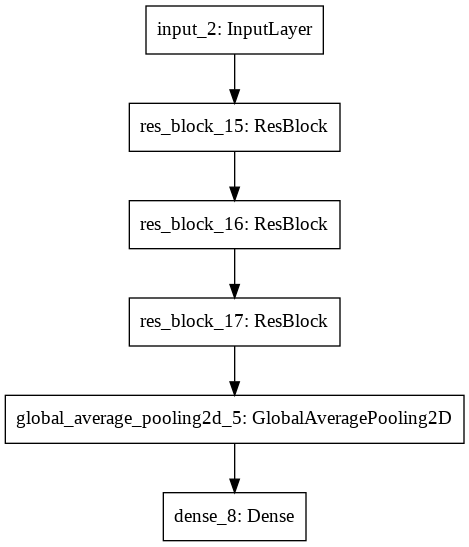

In [23]:
from tensorflow.keras.utils import plot_model 
plot_model(resnet_model.model())

In [31]:
class MyModel(tf.keras.Model):

  def __init__(self, num_classes = 10 , **kwargs):
    super(MyModel , self).__init__(**kwargs)
    self.dense1 = layers.Dense(64)
    self.dense2 = layers.Dense(num_classes)

  def call(self , input_tensor):
    x = tf.nn.relu(self.dense1(input_tensor))
    return self.dense2(x)


model = MyModel()
model.compile(optimizer = 'adam' , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True) , 
              metrics = ['accuracy'])

model.fit(X_train_new , y_train , batch_size = 32 , epochs = 3 , verbose = 2)

Epoch 1/3
1875/1875 - 3s - loss: 2.3015 - accuracy: 0.1117
Epoch 2/3
1875/1875 - 2s - loss: 2.3012 - accuracy: 0.1124
Epoch 3/3
1875/1875 - 2s - loss: 2.3009 - accuracy: 0.1124


In [32]:
# Creating a Relu 
class MyRelu(tf.keras.layers.Layer):

  def __init__(self):
    super(MyRelu , self).__init__()

  def call(self , x):
    return tf.math.maximum(x , 0)

## Making new Layers and Models via subclassing (From The docs) 

https://www.tensorflow.org/guide/keras/custom_layers_and_models#setup


Writing out every single code from this doc! 

In [33]:
# Making the imports beforehand 
import tensorflow as tf 
from tensorflow.keras import layers 

The Layer class encapsulates both a state (layers weights) and a transformation from inputs to outputs (a call method) for forward pass.

In [34]:
# Building a densely connected layer 
class Linear(tf.keras.layers.Layer):

  def __init__(self , units , input_dim, **kwargs):
    super(Linear , self).__init__(**kwargs)
    self.units = units 
    self.input_dim = input_dim 

    # Weights and biases 
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(
        initial_value = w_init(shape = (input_dim , units) ,  dtype = tf.float32) , trainable = True
    )

    b_init = tf.zeros_initializer()
    self.b = tf.Variable(
        initial_value = b_init(shape = (units ,)  , dtype = tf.float32)
    )

  # Forward propagation 
  def call(self, inputs):
    return tf.matmul(inputs , self.w) + self.b

In [36]:
# Passing a dummy input 
x = tf.ones((2 ,2))
linear_layer = Linear(units = 4 , input_dim = 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.03264646 -0.10319741  0.00261803 -0.01504993]
 [-0.03264646 -0.10319741  0.00261803 -0.01504993]], shape=(2, 4), dtype=float32)


In [41]:
x_ = tf.ones((2 , 4))
y_ = tf.ones((4,))

#tf.matmul(x , x_)
x.shape , x_.shape

(TensorShape([2, 2]), TensorShape([2, 4]))

Using the `add_weight()` method for quicker shortcut. 

In [43]:
class Linear(tf.keras.layers.Layer):

  def __init__(self, units, input_dim):
    super(Linear , self).__init__()
    self.w = self.add_weight(
        shape = (input_dim , units) , initializer = 'glorot_uniform' , trainable = True
    )
    self.b = self.add_weight(
        shape = (units,) , initializer = 'zeros' , trainable = True
    )

  def call(self, inputs):
    return tf.matmul(inputs , self.w) + self.b


linear_layer = Linear(4 ,2)
linear_layer(x)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.7560086 , -0.27888823, -1.5629225 ,  0.06975794],
       [ 0.7560086 , -0.27888823, -1.5629225 ,  0.06975794]],
      dtype=float32)>

Besides the trainable weights, we can even add non-trainable weights to a layer as well. 

> Such weights won't be taken into account during backprop or while training the layer.

In [46]:
class ComputeSum(tf.keras.layers.Layer):

  def __init__(self , input_dim , **kwargs):
    super(ComputeSum , self).__init__(**kwargs)

    self.total = tf.Variable(initial_value= tf.zeros((input_dim , )) , trainable= False)

  def call(self , inputs):
    self.total.assign_add(tf.reduce_sum(inputs , axis = 0))
    return self.total

In [52]:
x = tf.ones((2 , 2))
my_sum = ComputeSum(input_dim= 2)
my_sum(x)

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2., 2.], dtype=float32)>

#### **Best Practice** Deferring weight creation until the shape of the input is known. 

In many cases, we may nt know in advance the size of our inputs, and we would like to lazily create weights when the vaue becomes known, some time after instantiating the layer. 

We can do this by using the `build(self, input_shape)` method.


In [54]:
# Constructing a layer with the build method 

class Linear(tf.keras.layers.Layer):

  def __init__(self , units , **kwargs):
    super(Linear , self).__init__(**kwargs)

    self.units = units 

  def build(self , input_shape):
    self.w = self.add_weight(shape = (input_shape[-1] , self.units) , 
                             initializer = 'glorot_uniform' , 
                             trainable = True)
    
    self.b = self.add_weight(shape = (self.units ,) , 
                             initializer = 'zeros', trainable = True)
    
  
  def call(self, inputs):
    return tf.matmul(inputs , self.w) + self.b

x = tf.ones((2, 2))
b_layer = Linear(units = 12)
b_layer(x)

<tf.Tensor: shape=(2, 12), dtype=float32, numpy=
array([[ 0.6545361 ,  0.36266744,  0.9787259 , -0.30318925,  1.1140931 ,
         0.6644525 , -0.00476301, -0.31749135,  0.2563127 ,  0.8250067 ,
         0.2188679 , -0.24075866],
       [ 0.6545361 ,  0.36266744,  0.9787259 , -0.30318925,  1.1140931 ,
         0.6644525 , -0.00476301, -0.31749135,  0.2563127 ,  0.8250067 ,
         0.2188679 , -0.24075866]], dtype=float32)>

The `call()` method will automatically run the build the first time its called. 

Now our layer creates the weights through the build method and takes the dim from the input shape.

#### **Layers are recursively composable** 

We can use the Layer instance as an attribute of another Layer, the output layer will start tracking the weights of the inner layer. 

We will call these instances constructor or the init method. Since the sublayers will typically have a build mehtod, they will be built when the outer layer gets built. 

In [71]:
# We are re-using the Linear class which was built above 
# Make sure it has the build method 


class MLPBlock(tf.keras.layers.Layer):

  def __init__(self , **kwargs):
    super(MLPBlock , self).__init__(**kwargs)

    self.linear_1 = Linear(32)
    self.linear_2 = Linear(32)
    self.linear_3 = Linear(1)

  def call(self , inputs):
    x = self.linear_1(inputs)
    x = tf.nn.relu(x)
    x = self.linear_2(x)
    x = tf.nn.relu(x)
    return self.linear_3(x)
  
  def model(self , input_shape):
    x = layers.Input(shape = input_shape)
    return tf.keras.Model(inputs = [x] , outputs = self.call(x))

mlp = MLPBlock()
x_new = tf.ones((3 , 64))
new_model = mlp.model(x_new.shape)
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 64)]           0         
_________________________________________________________________
linear_41 (Linear)           (None, 3, 32)             2080      
_________________________________________________________________
tf.nn.relu_2 (TFOpLambda)    (None, 3, 32)             0         
_________________________________________________________________
linear_42 (Linear)           (None, 3, 32)             1056      
_________________________________________________________________
tf.nn.relu_3 (TFOpLambda)    (None, 3, 32)             0         
_________________________________________________________________
linear_43 (Linear)           (None, 3, 1)              33        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________

In [59]:
Linear(32)(x)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[ 0.43154544,  0.20031127,  0.05356804, -0.5117223 ,  0.23156342,
        -0.42638555, -0.23026729,  0.21616405,  0.02342704, -0.4331713 ,
        -0.08822438,  0.10264812,  0.5390112 , -0.26971427, -0.7056853 ,
         0.27737316,  0.17170075, -0.01220515,  0.1279693 ,  0.3457061 ,
        -0.47503495,  0.10932532,  0.411958  , -0.63879704,  0.0115537 ,
        -0.28038555, -0.12765104, -0.5820263 , -0.36577123, -0.28264078,
        -0.05403408, -0.3133632 ],
       [ 0.43154544,  0.20031127,  0.05356804, -0.5117223 ,  0.23156342,
        -0.42638555, -0.23026729,  0.21616405,  0.02342704, -0.4331713 ,
        -0.08822438,  0.10264812,  0.5390112 , -0.26971427, -0.7056853 ,
         0.27737316,  0.17170075, -0.01220515,  0.1279693 ,  0.3457061 ,
        -0.47503495,  0.10932532,  0.411958  , -0.63879704,  0.0115537 ,
        -0.28038555, -0.12765104, -0.5820263 , -0.36577123, -0.28264078,
        -0.05403408, -0.3133632 ]], dtyp

In [ ]:
def model(self):
    x = layers.Input(shape = (28 , 28 , 1))
    return tf.keras.Model(inputs = [x] , outputs = self.call(x))
